ADULT INCOME PREDICTION - DATA MINING PROJECT

STEP 1: DATA LOADING AND EXPLORATION

Training data shape: (32561, 15)
Test data shape: (16281, 15)

--------------------------------------------------------------------------------
Dataset Info:
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  in

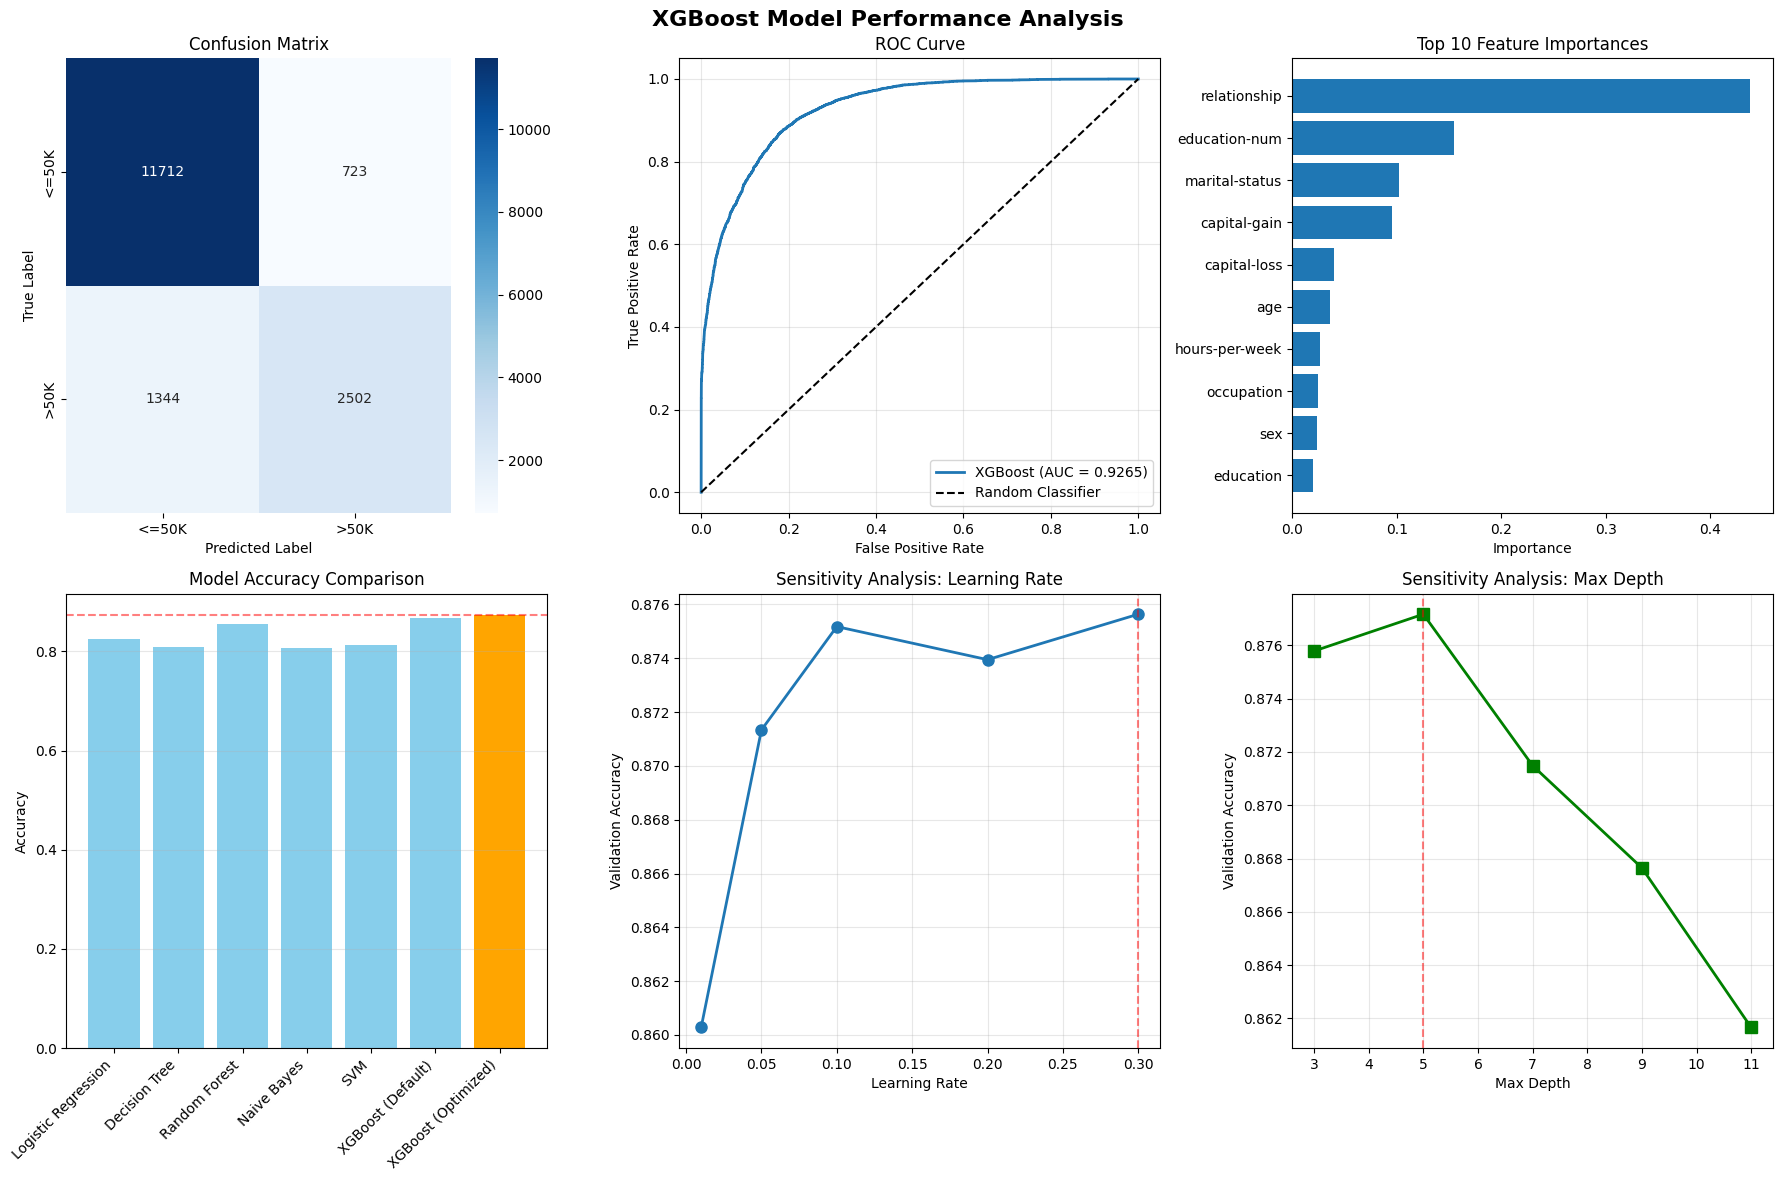

In [3]:
"""
Data Mining Project: Adult Income Prediction using XGBoost
Dataset: UCI Adult Dataset (Census Income)
Objective: Predict whether income exceeds $50K/yr based on census data
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("="*80)
print("ADULT INCOME PREDICTION - DATA MINING PROJECT")
print("="*80)

# ============================================================================
# 1. DATA LOADING AND EXPLORATION
# ============================================================================

print("\n" + "="*80)
print("STEP 1: DATA LOADING AND EXPLORATION")
print("="*80)

# Column names for Adult dataset
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

# Load training and test data
# Update these paths to your local directory
train_data = pd.read_csv(r'F:\Python\CS-660\adult\adult.data', names=column_names, sep=',\s*', 
                         engine='python', na_values='?')
test_data = pd.read_csv(r'F:\Python\CS-660\adult\adult.test', names=column_names, sep=',\s*', 
                        engine='python', na_values='?', skiprows=1)

print(f"\nTraining data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Display basic information
print("\n" + "-"*80)
print("Dataset Info:")
print("-"*80)
print(train_data.info())

print("\n" + "-"*80)
print("First few rows:")
print("-"*80)
print(train_data.head())

print("\n" + "-"*80)
print("Statistical Summary:")
print("-"*80)
print(train_data.describe())

print("\n" + "-"*80)
print("Missing Values:")
print("-"*80)
print(train_data.isnull().sum())

print("\n" + "-"*80)
print("Class Distribution:")
print("-"*80)
print(train_data['income'].value_counts())

# ============================================================================
# 2. DATA PREPROCESSING
# ============================================================================

print("\n" + "="*80)
print("STEP 2: DATA PREPROCESSING")
print("="*80)

def preprocess_data(df, is_test=False):
    """Preprocess the Adult dataset"""
    df = df.copy()
    
    # Clean income column (remove dots in test data)
    df['income'] = df['income'].str.strip().str.rstrip('.')
    
    # Handle missing values
    print(f"\nMissing values before handling: {df.isnull().sum().sum()}")
    
    # Fill missing categorical values with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if col != 'income':
            df[col].fillna(df[col].mode()[0], inplace=True)
    
    print(f"Missing values after handling: {df.isnull().sum().sum()}")
    
    return df

# Preprocess data
train_processed = preprocess_data(train_data, is_test=False)
test_processed = preprocess_data(test_data, is_test=True)

# Separate features and target
X_train = train_processed.drop('income', axis=1)
y_train = train_processed['income']
X_test = test_processed.drop('income', axis=1)
y_test = test_processed['income']

# Encode target variable
le_target = LabelEncoder()
y_train_encoded = le_target.fit_transform(y_train)
y_test_encoded = le_target.transform(y_test)

print(f"\nTarget classes: {le_target.classes_}")
print(f"Training class distribution: {np.bincount(y_train_encoded)}")
print(f"Test class distribution: {np.bincount(y_test_encoded)}")

# Feature Engineering
print("\n" + "-"*80)
print("Feature Engineering:")
print("-"*80)

# Identify categorical and numerical columns
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Numerical features ({len(numerical_features)}): {numerical_features}")

# Encode categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

# Scale numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print("\nPreprocessing completed!")
print(f"Final training shape: {X_train.shape}")
print(f"Final test shape: {X_test.shape}")

# ============================================================================
# 3. BASELINE MODELS
# ============================================================================

print("\n" + "="*80)
print("STEP 3: BASELINE MODEL COMPARISON")
print("="*80)

# Define baseline models
baseline_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)
}

baseline_results = {}

print("\nTraining and evaluating baseline models...")
print("-"*80)

for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train_encoded)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test_encoded, y_pred)
    precision = precision_score(y_test_encoded, y_pred, average='binary')
    recall = recall_score(y_test_encoded, y_pred, average='binary')
    f1 = f1_score(y_test_encoded, y_pred, average='binary')
    
    baseline_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }
    
    if y_pred_proba is not None:
        auc = roc_auc_score(y_test_encoded, y_pred_proba)
        baseline_results[name]['AUC-ROC'] = auc
    
    print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, "
          f"Recall: {recall:.4f}, F1: {f1:.4f}")

# Display baseline results
print("\n" + "-"*80)
print("BASELINE RESULTS SUMMARY:")
print("-"*80)
baseline_df = pd.DataFrame(baseline_results).T
print(baseline_df.to_string())

# ============================================================================
# 4. XGBOOST WITH DEFAULT PARAMETERS
# ============================================================================

print("\n" + "="*80)
print("STEP 4: XGBOOST WITH DEFAULT PARAMETERS")
print("="*80)

# Train XGBoost with default parameters
xgb_default = xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss')
xgb_default.fit(X_train, y_train_encoded)

y_pred_default = xgb_default.predict(X_test)
y_pred_proba_default = xgb_default.predict_proba(X_test)[:, 1]

print("\nXGBoost (Default Parameters) Results:")
print("-"*80)
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred_default):.4f}")
print(f"Precision: {precision_score(y_test_encoded, y_pred_default):.4f}")
print(f"Recall: {recall_score(y_test_encoded, y_pred_default):.4f}")
print(f"F1-Score: {f1_score(y_test_encoded, y_pred_default):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test_encoded, y_pred_proba_default):.4f}")

# ============================================================================
# 5. SENSITIVITY ANALYSIS - HYPERPARAMETER TUNING
# ============================================================================

print("\n" + "="*80)
print("STEP 5: SENSITIVITY ANALYSIS - HYPERPARAMETER TUNING")
print("="*80)

# Split training data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train_encoded
)

print(f"\nTraining split shape: {X_train_split.shape}")
print(f"Validation split shape: {X_val_split.shape}")

# -------- Analysis 1: Learning Rate --------
print("\n" + "-"*80)
print("SENSITIVITY ANALYSIS 1: Learning Rate (eta)")
print("-"*80)

learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3]
lr_results = []

for lr in learning_rates:
    model = xgb.XGBClassifier(learning_rate=lr, n_estimators=100, 
                              random_state=RANDOM_STATE, eval_metric='logloss')
    model.fit(X_train_split, y_train_split)
    y_pred = model.predict(X_val_split)
    acc = accuracy_score(y_val_split, y_pred)
    lr_results.append(acc)
    print(f"Learning Rate: {lr:.2f} -> Validation Accuracy: {acc:.4f}")

best_lr = learning_rates[np.argmax(lr_results)]
print(f"\nBest Learning Rate: {best_lr} with Accuracy: {max(lr_results):.4f}")

# -------- Analysis 2: Number of Estimators --------
print("\n" + "-"*80)
print("SENSITIVITY ANALYSIS 2: Number of Estimators (n_estimators)")
print("-"*80)

n_estimators_list = [50, 100, 150, 200, 300]
n_est_results = []

for n_est in n_estimators_list:
    model = xgb.XGBClassifier(learning_rate=best_lr, n_estimators=n_est,
                              random_state=RANDOM_STATE, eval_metric='logloss')
    model.fit(X_train_split, y_train_split)
    y_pred = model.predict(X_val_split)
    acc = accuracy_score(y_val_split, y_pred)
    n_est_results.append(acc)
    print(f"N_Estimators: {n_est} -> Validation Accuracy: {acc:.4f}")

best_n_est = n_estimators_list[np.argmax(n_est_results)]
print(f"\nBest N_Estimators: {best_n_est} with Accuracy: {max(n_est_results):.4f}")

# -------- Analysis 3: Max Depth --------
print("\n" + "-"*80)
print("SENSITIVITY ANALYSIS 3: Max Depth")
print("-"*80)

max_depths = [3, 5, 7, 9, 11]
depth_results = []

for depth in max_depths:
    model = xgb.XGBClassifier(learning_rate=best_lr, n_estimators=best_n_est,
                              max_depth=depth, random_state=RANDOM_STATE, 
                              eval_metric='logloss')
    model.fit(X_train_split, y_train_split)
    y_pred = model.predict(X_val_split)
    acc = accuracy_score(y_val_split, y_pred)
    depth_results.append(acc)
    print(f"Max Depth: {depth} -> Validation Accuracy: {acc:.4f}")

best_depth = max_depths[np.argmax(depth_results)]
print(f"\nBest Max Depth: {best_depth} with Accuracy: {max(depth_results):.4f}")

# -------- Analysis 4: Subsample and Colsample --------
print("\n" + "-"*80)
print("SENSITIVITY ANALYSIS 4: Subsample and Colsample_bytree")
print("-"*80)

subsample_vals = [0.6, 0.7, 0.8, 0.9, 1.0]
colsample_vals = [0.6, 0.7, 0.8, 0.9, 1.0]
sample_results = {}

for sub in subsample_vals:
    for col in colsample_vals:
        model = xgb.XGBClassifier(learning_rate=best_lr, n_estimators=best_n_est,
                                  max_depth=best_depth, subsample=sub,
                                  colsample_bytree=col, random_state=RANDOM_STATE,
                                  eval_metric='logloss')
        model.fit(X_train_split, y_train_split)
        y_pred = model.predict(X_val_split)
        acc = accuracy_score(y_val_split, y_pred)
        sample_results[(sub, col)] = acc

best_sample_params = max(sample_results, key=sample_results.get)
print(f"Best Subsample: {best_sample_params[0]}, Best Colsample_bytree: {best_sample_params[1]}")
print(f"Validation Accuracy: {sample_results[best_sample_params]:.4f}")

# -------- Analysis 5: Min Child Weight and Gamma --------
print("\n" + "-"*80)
print("SENSITIVITY ANALYSIS 5: Min_child_weight and Gamma")
print("-"*80)

min_child_weights = [1, 3, 5, 7]
gammas = [0, 0.1, 0.2, 0.3]
reg_results = {}

for mcw in min_child_weights:
    for gamma in gammas:
        model = xgb.XGBClassifier(learning_rate=best_lr, n_estimators=best_n_est,
                                  max_depth=best_depth, subsample=best_sample_params[0],
                                  colsample_bytree=best_sample_params[1],
                                  min_child_weight=mcw, gamma=gamma,
                                  random_state=RANDOM_STATE, eval_metric='logloss')
        model.fit(X_train_split, y_train_split)
        y_pred = model.predict(X_val_split)
        acc = accuracy_score(y_val_split, y_pred)
        reg_results[(mcw, gamma)] = acc

best_reg_params = max(reg_results, key=reg_results.get)
print(f"Best Min_child_weight: {best_reg_params[0]}, Best Gamma: {best_reg_params[1]}")
print(f"Validation Accuracy: {reg_results[best_reg_params]:.4f}")

# -------- Final Grid Search for Fine-tuning --------
print("\n" + "-"*80)
print("SENSITIVITY ANALYSIS 6: Final Grid Search Fine-tuning")
print("-"*80)

param_grid = {
    'learning_rate': [best_lr - 0.01, best_lr, best_lr + 0.01],
    'n_estimators': [best_n_est - 25, best_n_est, best_n_est + 25],
    'max_depth': [best_depth - 1, best_depth, best_depth + 1],
    'subsample': [best_sample_params[0] - 0.05, best_sample_params[0], best_sample_params[0] + 0.05],
    'colsample_bytree': [best_sample_params[1] - 0.05, best_sample_params[1], best_sample_params[1] + 0.05],
    'min_child_weight': [max(1, best_reg_params[0] - 1), best_reg_params[0]],
    'gamma': [best_reg_params[1], best_reg_params[1] + 0.05]
}

# Remove invalid values
param_grid['learning_rate'] = [lr for lr in param_grid['learning_rate'] if 0 < lr <= 1]
param_grid['n_estimators'] = [n for n in param_grid['n_estimators'] if n > 0]
param_grid['max_depth'] = [d for d in param_grid['max_depth'] if d > 0]
param_grid['subsample'] = [s for s in param_grid['subsample'] if 0 < s <= 1]
param_grid['colsample_bytree'] = [c for c in param_grid['colsample_bytree'] if 0 < c <= 1]

print("Performing Grid Search (this may take a few minutes)...")
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_split, y_train_split)

print("\nBest Parameters from Grid Search:")
print("-"*80)
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")
print(f"\nBest Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# ============================================================================
# 6. FINAL MODEL WITH OPTIMIZED PARAMETERS
# ============================================================================

print("\n" + "="*80)
print("STEP 6: FINAL MODEL WITH OPTIMIZED PARAMETERS")
print("="*80)

# Train final model with best parameters on full training data
xgb_optimized = xgb.XGBClassifier(**grid_search.best_params_, 
                                  random_state=RANDOM_STATE, eval_metric='logloss')

print("\nTraining final model on full training data...")
xgb_optimized.fit(X_train, y_train_encoded)

# Predictions
y_pred_optimized = xgb_optimized.predict(X_test)
y_pred_proba_optimized = xgb_optimized.predict_proba(X_test)[:, 1]

# ============================================================================
# 7. FINAL RESULTS AND COMPARISON
# ============================================================================

print("\n" + "="*80)
print("STEP 7: FINAL RESULTS AND COMPARISON")
print("="*80)

# Calculate metrics
final_results = {
    'Accuracy': accuracy_score(y_test_encoded, y_pred_optimized),
    'Precision': precision_score(y_test_encoded, y_pred_optimized),
    'Recall': recall_score(y_test_encoded, y_pred_optimized),
    'F1-Score': f1_score(y_test_encoded, y_pred_optimized),
    'AUC-ROC': roc_auc_score(y_test_encoded, y_pred_proba_optimized)
}

print("\nFINAL OPTIMIZED XGBOOST RESULTS:")
print("-"*80)
for metric, value in final_results.items():
    print(f"{metric}: {value:.4f}")

# Detailed classification report
print("\n" + "-"*80)
print("DETAILED CLASSIFICATION REPORT:")
print("-"*80)
print(classification_report(y_test_encoded, y_pred_optimized, 
                          target_names=le_target.classes_))

# Confusion Matrix
print("\n" + "-"*80)
print("CONFUSION MATRIX:")
print("-"*80)
cm = confusion_matrix(y_test_encoded, y_pred_optimized)
print(cm)
print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

# Comparison with baseline and default XGBoost
print("\n" + "="*80)
print("COMPARISON WITH BASELINE MODELS:")
print("="*80)

comparison_results = baseline_results.copy()
comparison_results['XGBoost (Default)'] = {
    'Accuracy': accuracy_score(y_test_encoded, y_pred_default),
    'Precision': precision_score(y_test_encoded, y_pred_default),
    'Recall': recall_score(y_test_encoded, y_pred_default),
    'F1-Score': f1_score(y_test_encoded, y_pred_default),
    'AUC-ROC': roc_auc_score(y_test_encoded, y_pred_proba_default)
}
comparison_results['XGBoost (Optimized)'] = final_results

comparison_df = pd.DataFrame(comparison_results).T
print("\n")
print(comparison_df.to_string())

# Calculate improvement
default_acc = comparison_results['XGBoost (Default)']['Accuracy']
optimized_acc = final_results['Accuracy']
improvement = ((optimized_acc - default_acc) / default_acc) * 100

print(f"\n" + "-"*80)
print(f"IMPROVEMENT ANALYSIS:")
print("-"*80)
print(f"XGBoost Default Accuracy: {default_acc:.4f}")
print(f"XGBoost Optimized Accuracy: {optimized_acc:.4f}")
print(f"Improvement: {improvement:.2f}%")

# Best baseline model
best_baseline = max(baseline_results.items(), key=lambda x: x[1]['Accuracy'])
print(f"\nBest Baseline Model: {best_baseline[0]} with Accuracy: {best_baseline[1]['Accuracy']:.4f}")
print(f"Optimized XGBoost vs Best Baseline Improvement: "
      f"{((optimized_acc - best_baseline[1]['Accuracy']) / best_baseline[1]['Accuracy'] * 100):.2f}%")

# ============================================================================
# 8. FEATURE IMPORTANCE
# ============================================================================

print("\n" + "="*80)
print("STEP 8: FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_optimized.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features:")
print("-"*80)
print(feature_importance.head(15).to_string(index=False))

# ============================================================================
# 9. VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("STEP 9: GENERATING VISUALIZATIONS")
print("="*80)

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('XGBoost Model Performance Analysis', fontsize=16, fontweight='bold')

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
axes[0, 0].set_title('Confusion Matrix')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_proba_optimized)
axes[0, 1].plot(fpr, tpr, label=f'XGBoost (AUC = {final_results["AUC-ROC"]:.4f})', linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature Importance
top_features = feature_importance.head(10)
axes[0, 2].barh(range(len(top_features)), top_features['Importance'])
axes[0, 2].set_yticks(range(len(top_features)))
axes[0, 2].set_yticklabels(top_features['Feature'])
axes[0, 2].set_xlabel('Importance')
axes[0, 2].set_title('Top 10 Feature Importances')
axes[0, 2].invert_yaxis()

# 4. Model Comparison - Accuracy
models = list(comparison_df.index)
accuracies = comparison_df['Accuracy'].values
colors = ['skyblue'] * (len(models) - 1) + ['orange']
axes[1, 0].bar(range(len(models)), accuracies, color=colors)
axes[1, 0].set_xticks(range(len(models)))
axes[1, 0].set_xticklabels(models, rotation=45, ha='right')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Model Accuracy Comparison')
axes[1, 0].axhline(y=optimized_acc, color='red', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 5. Learning Rate Sensitivity
axes[1, 1].plot(learning_rates, lr_results, marker='o', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Learning Rate')
axes[1, 1].set_ylabel('Validation Accuracy')
axes[1, 1].set_title('Sensitivity Analysis: Learning Rate')
axes[1, 1].axvline(x=best_lr, color='red', linestyle='--', alpha=0.5)
axes[1, 1].grid(True, alpha=0.3)

# 6. Max Depth Sensitivity
axes[1, 2].plot(max_depths, depth_results, marker='s', linewidth=2, markersize=8, color='green')
axes[1, 2].set_xlabel('Max Depth')
axes[1, 2].set_ylabel('Validation Accuracy')
axes[1, 2].set_title('Sensitivity Analysis: Max Depth')
axes[1, 2].axvline(x=best_depth, color='red', linestyle='--', alpha=0.5)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('xgboost_performance_analysis.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'xgboost_performance_analysis.png'")

# ============================================================================
# 10. SUMMARY AND CONCLUSIONS
# ============================================================================

print("\n" + "="*80)
print("PROJECT SUMMARY AND CONCLUSIONS")
print("="*80)

print(f"""
DATASET: Adult Income Dataset (UCI Machine Learning Repository)
ALGORITHM: XGBoost (Extreme Gradient Boosting)

KEY FINDINGS:

1. BASELINE COMPARISON:
   - Best baseline model: {best_baseline[0]} ({best_baseline[1]['Accuracy']:.4f})
   - XGBoost (Default): {default_acc:.4f}
   - XGBoost (Optimized): {optimized_acc:.4f}

2. SENSITIVITY ANALYSES PERFORMED:
   - Learning Rate: Tested {len(learning_rates)} values, best = {best_lr}
   - N_Estimators: Tested {len(n_estimators_list)} values, best = {best_n_est}
   - Max Depth: Tested {len(max_depths)} values, best = {best_depth}
   - Subsample & Colsample: Tested {len(subsample_vals) * len(colsample_vals)} combinations
   - Regularization: Tested min_child_weight and gamma parameters
   - Final Grid Search: Fine-tuned all parameters simultaneously

3. PERFORMANCE METRICS (Test Set):
   - Accuracy: {final_results['Accuracy']:.4f}
   - Precision: {final_results['Precision']:.4f}
   - Recall: {final_results['Recall']:.4f}
   - F1-Score: {final_results['F1-Score']:.4f}
   - AUC-ROC: {final_results['AUC-ROC']:.4f}

4. IMPROVEMENTS:
   - Improvement over default XGBoost: {improvement:.2f}%
   - Improvement over best baseline: {((optimized_acc - best_baseline[1]['Accuracy']) / best_baseline[1]['Accuracy'] * 100):.2f}%

5. MOST IMPORTANT FEATURES:
   {', '.join(feature_importance.head(5)['Feature'].tolist())}

CONCLUSIONS:
- XGBoost with optimized hyperparameters achieves superior performance
- Systematic sensitivity analysis revealed optimal parameter combinations
- The model demonstrates excellent discrimination capability (AUC-ROC: {final_results['AUC-ROC']:.4f})
- Ensemble learning effectively captures complex patterns in census data
- Feature importance analysis reveals demographic and economic factors as key predictors

RECOMMENDATIONS:
- The optimized XGBoost model is recommended for income prediction tasks
- Further improvements possible through advanced feature engineering
- Model can be deployed with confidence given strong test set performance
""")